## SAT solvers

SAT solver is a program that solves boolean satisfiability problem.

Solving boolean satisfiability problem is a fancy way of saying: "find values of boolean variables, such that boolean formula is true".

E.g. boolean formula `X and Y` is true when X is true and Y is true.
The same variable can be encountered many times in a formula (`X and (Y or not X) and (Z or not Y)`). That's why solving boolean satisfiability is a hard problem. No known polynomial algorithm exists.

But there are SAT solvers that use heuristics for optimizations and can give pretty good results even on the formulas with thousand variables. One of these solvers is [PySAT](https://pysathq.github.io)

In [1]:
from pysat.formula import CNF
from pysat.solvers import Solver
import matplotlib.pyplot as plt
%matplotlib inline

PySAT solves boolean problems represented in CNF.

CNF is a fancy way of saying: "Conjunctive normal form".

Conjunction is fancy way of saying: "AND"

Conjunctive normal form looks like `(X or Y or Z) and (not X or T or z)`. Nested clauses can have only `or` and simple negation. Nested clauses are connected via `and`.

In [2]:
def solve(clauses):
    cnf = CNF(from_clauses=clauses)
    with Solver(bootstrap_with=cnf) as solver:
        if solver.solve():
            return solver.get_model()

solve([[1], [2]])  # 1 is a variable, 2 is another variable, this represents `1 AND 2`

[1, 2]

`[1, 2]` means that our boolean formula is true when 1 is true and when 2 is true.

-1 or -2 means negation of variable 1 or 2.

In [3]:
solve([[-1, -2], [1, 2]])  # `(NOT 1 or NOT 2) AND (1 OR 2)

[1, -2]

Many problems can be converted to SAT.

Let's solve [N queens puzzle](https://en.wikipedia.org/wiki/Eight_queens_puzzle) using SAT solver.

In [4]:
import itertools


def n_of(ns, variables):
    """
    Generate cnf that is true when exactly ns[0] or ns[1] ... or ns[-1] variables are true
    """
    not_n_of_dnf = []
    for n in range(0, len(variables) + 1):
        if n in ns:
            continue
        for true_vars in itertools.combinations(variables, n):
            true_vars = set(true_vars)
            false_vars = [-v for v in variables if v not in true_vars]
            not_n_of_dnf.append(list(true_vars) + false_vars)
    return negate_dnf_to_cnf(not_n_of_dnf)


def negate_dnf_to_cnf(dnf):
    return [
        [-var for var in clause]
        for clause in dnf
    ]

n_of(ns=[1], variables=[1, 2])  # this represents XOR

[[1, 2], [-1, -2]]

We represent every square on the chessboard with the boolean variable that is true when it contains a queen. With this representation we just need to solve the formula: each row/vertical/diagonal should contain <= 1 queen. And we should have n queens total. SAT solver can do it for us.

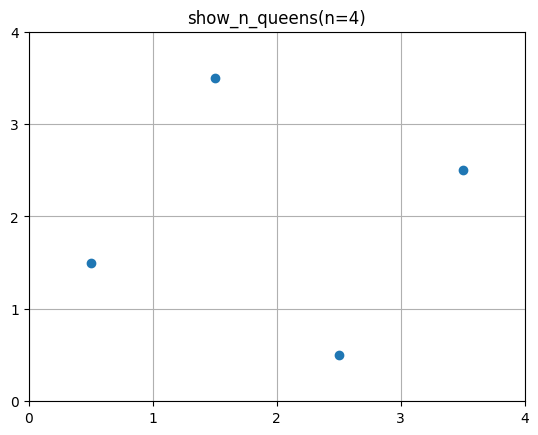

In [13]:
import numpy as np

def to_int_list(array):
    return [int(item) for item in array]

def solve_n_queens(n):
    variables = np.arange(1, n ** 2 + 1)
    board = variables.reshape(n, n)
    cnf = []
    cnf.extend(n_of(ns=[n], variables=to_int_list(variables)))
    for i in range(n):
        row = board[i]
        column = board[:,i]
        diagonal1 = np.diagonal(board, offset=i)
        diagonal2 = np.diagonal(board, offset=-i)
        diagonal3 = np.diagonal(np.fliplr(board), offset=i)
        diagonal4 = np.diagonal(np.fliplr(board), offset=-i)
        
        cnf.extend(n_of(ns=[0, 1], variables=to_int_list(row)))
        cnf.extend(n_of(ns=[0, 1], variables=to_int_list(column)))
        cnf.extend(n_of(ns=[0, 1], variables=to_int_list(diagonal1)))
        cnf.extend(n_of(ns=[0, 1], variables=to_int_list(diagonal2)))
        cnf.extend(n_of(ns=[0, 1], variables=to_int_list(diagonal3)))
        cnf.extend(n_of(ns=[0, 1], variables=to_int_list(diagonal4)))
    return solve(cnf)


def show_n_queens(n):
    values = solve_n_queens(n)
    if values is None:
        print(f'no solution for show_n_queens({n=})')
        return
    xs = []
    ys = []
    for a_value in values:
        if a_value > 0:
            y, x = divmod(a_value - 1, n)
            xs.append(x + 0.5)
            ys.append(y + 0.5)
    plt.scatter(xs, ys)
    plt.xticks(range(n + 1))
    plt.yticks(range(n + 1))
    plt.grid(True)
    plt.title(f'show_n_queens({n=})')
    plt.show()
    

# TODO: why does it TLE for solve_n_queens(5)?
show_n_queens(4)
